## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration

The camera calibration is necessary for the project because it employs the polynominal curve fitting to get the curvature of lane line. A distorted image would give you a very wrong lane curvature.

The code cell below uses the `cv2.findChessboardCorners()` function to find 2D corner points in the given chessboard image which are corresponding to real world 3D points. It needs at least 10 test chessboard images to find the good mapping. After the sufficient mappings found, I uses the `cv2.calibrateCamera()` function to get the camera calibration matrix and distortion coefficients. 

In [1]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

''' 
Calibrate the given camera with chessboard pictures taken by the camera from 
various angles. It returns the camera matrix and the distortion coefficients.

'''
def calibrate_camera():
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # x, y coordinates

    images = glob.glob("camera_cal/calibration*.jpg")

    for fname in images:
        img = cv2.imread(fname)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    return mtx, dist

# This function should be called only once.
mtx, dist = calibrate_camera()

## Constants and Tuning parameters

Below are constants and parameters to tune that will be used in the pipeline.

In [2]:
# Debugging flag
DEBUG = False

# Define conversions in x and y from pixels space to meters
# The values are derived from the warped image.
ym_per_pix = 12 / 720 # meters per pixel in y dimension
xm_per_pix = 3.7 / 880 # meters per pixel in x dimension

# Moving average running number
MOVING_AVERAGE_N = 5

# The source points for the perspective transform
perspective_transform_src = np.float32(
        [[555, 475],
         [730, 475],
         [1060, 680],
         [240, 680]])

# The width of the windows +/- margin
margin = 100

# White color threshold
WHITE_THRESHOLD = 185

# Yellow color threshold
YELLOW_THRESHOLD = 150

## Distortion correction

Images are corrected by using the `cv2.undistort()` function with the camera calibration matrix and distortion coefficients computed above.

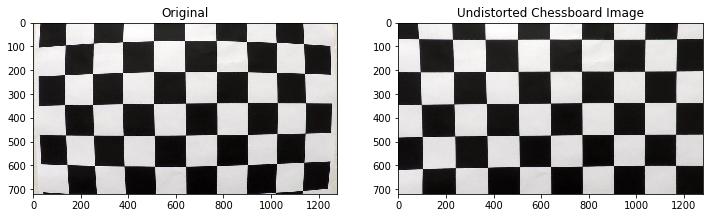

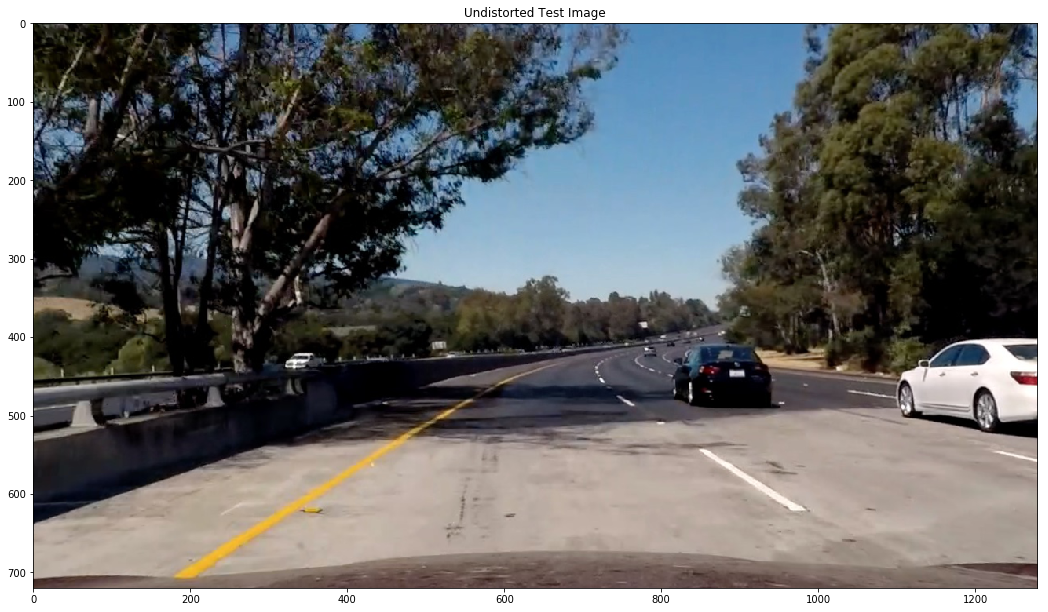

In [3]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)


img = mpimg.imread("camera_cal/calibration1.jpg")
undist = undistort(img, mtx, dist)

fig = plt.figure(figsize=(12, 6))  
subplot = fig.add_subplot(121)
subplot.imshow(img, cmap='gray')
subplot.set_title("Original")

subplot = fig.add_subplot(122)
subplot.imshow(undist, cmap='gray')
subplot.set_title("Undistorted Chessboard Image")
plt.show()

img = mpimg.imread("test_images/test5.jpg")
test_undist = undistort(img, mtx, dist)
plt.figure(figsize=(18, 16))
plt.title('Undistorted Test Image')
plt.imshow(test_undist)
plt.show()


## Color Thresholding

I use color thresholds to find white color and yellow color in the image. It's proved to be robust enough to find lane lines in both project video and challenge video.

The B channel in RGB color space works quite well on detecting white color. 

The yellow color is detected by using the b channel in LAB color space.

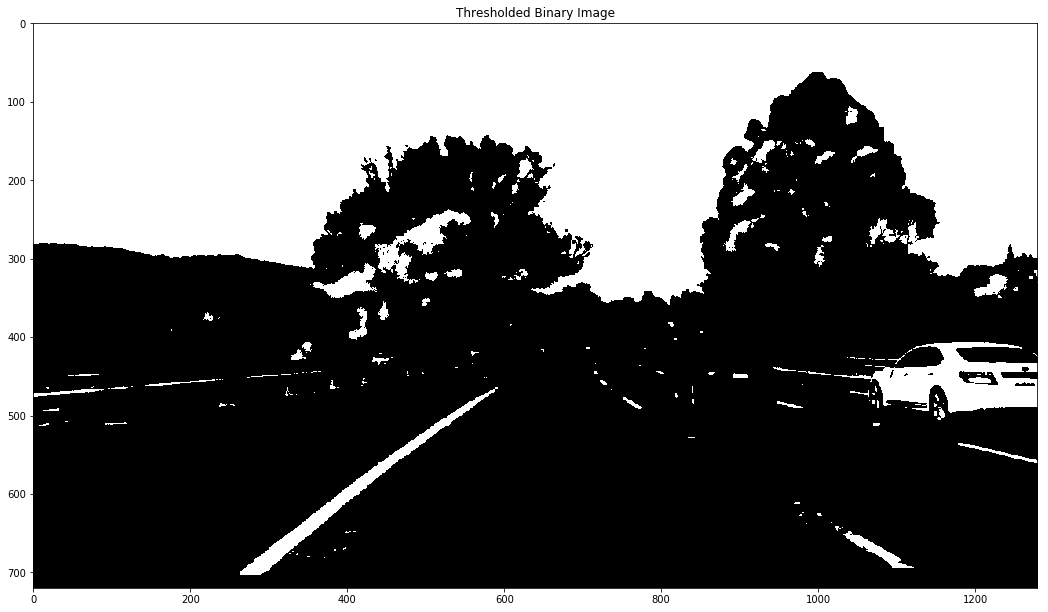

In [4]:
def white_thresh(img, thresh=128):
    color_channel = img[:,:,2]
    binary_output = np.zeros_like(color_channel)
    binary_output[color_channel > thresh] = 1
    
    return binary_output


def yellow_thresh(img, thresh=128):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l_channel,a_channel,b_channel = cv2.split(lab)
    binary_output = np.zeros_like(b_channel)
    binary_output[b_channel > thresh] = 1
    
    return binary_output


def thresholded_binary_image(img):
    # Search white color
    white_binary = white_thresh(img, thresh=WHITE_THRESHOLD)
    
    # Search yellow color
    yellow_binary = yellow_thresh(img, thresh=YELLOW_THRESHOLD)

    # Combine the yellow and white filtered result
    combined = np.zeros_like(yellow_binary)
    combined[((white_binary == 1) | (yellow_binary == 1))] = 1
    
    return combined, white_binary, yellow_binary
   

img = mpimg.imread('test_images/test1.jpg')
undist = undistort(img, mtx, dist)

thresholded, white, yellow = thresholded_binary_image(undist)
plt.figure(figsize=(18, 16))
plt.title('Thresholded Binary Image')
plt.imshow(thresholded, cmap='gray')
plt.show()

## Perspective transform

This step is required to get a bird's-eye view of the lane so that we can easily compute the curvature. Here I use the `cv2.getPerspectiveTransform()` function to perforam a perspective transform. It takes source and destination points as inputs. Both points are static and the source points found by eyeballing the test image (`test_images/straight_lines1.jpg`)

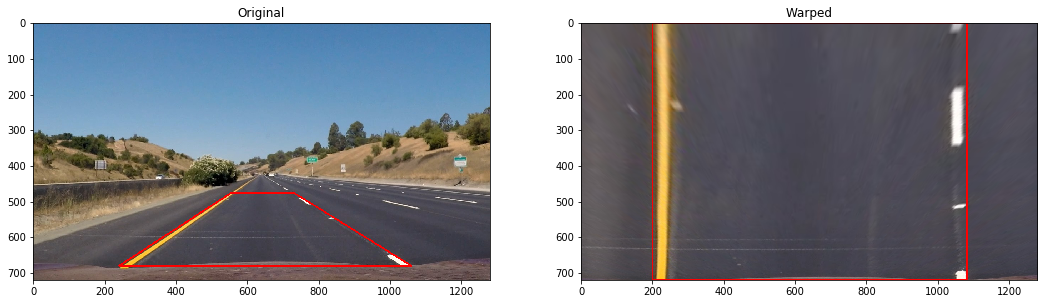

In [5]:
def draw_roi(img, vertices):
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.polylines(img, vertices, 1, (255, 0, 0), thickness=3)

    return


def warp_image(img, show_roi=False):
    offset = 200 # offset for dst points
    img_size = (img.shape[1], img.shape[0])

    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], 
                                     [img_size[0]-offset, img_size[1]], 
                                     [offset, img_size[1]]])

    M = cv2.getPerspectiveTransform(perspective_transform_src, dst)
    Minv = cv2.getPerspectiveTransform(dst, perspective_transform_src)
    warped = cv2.warpPerspective(img, M, img_size)    

    if show_roi is True:
        vertices = np.array([dst], dtype=np.int32)
        draw_roi(warped, vertices)
    
    return warped, Minv


test_img_path = 'test_images/straight_lines1.jpg'

img = mpimg.imread(test_img_path)
vertices = np.array([perspective_transform_src], dtype=np.int32)
draw_roi(img, vertices)

fig = plt.figure(figsize=(18, 8))  
subplot = fig.add_subplot(121)
subplot.imshow(img, cmap='gray')
subplot.set_title("Original")

img = mpimg.imread(test_img_path)
warped, Minv = warp_image(img, show_roi=True)

subplot = fig.add_subplot(122)
subplot.imshow(warped, cmap='gray')
subplot.set_title("Warped")
plt.show()


## Measure Lane Curvature and the Position of the Vehicle

The following functions measure the lane curvature and the position of the vehicle with respect to center.

In [6]:
def lane_curvature(fity, left_fitx, right_fitx):
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(fity*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(fity*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Compute the radius of curvature at the bottom of the image
    y_eval = np.max(fity)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


def vehicle_pos(img, left_fitx, right_fitx):
    # The midpoint at the bottom of the image between the left and the right line
    camera_center = (left_fitx[-1] + right_fitx[-1]) // 2
    
    return (img.shape[1] // 2 - camera_center) * xm_per_pix
    

## Find the lines

Here I use the histogram to find the peak X positions and search upward from those position to find lane lines. The newly detected lane line would be rejected if its curvature was deviated too far from the previous one. The result is smoothed over the last 5 frames of video to have a more stable lines.

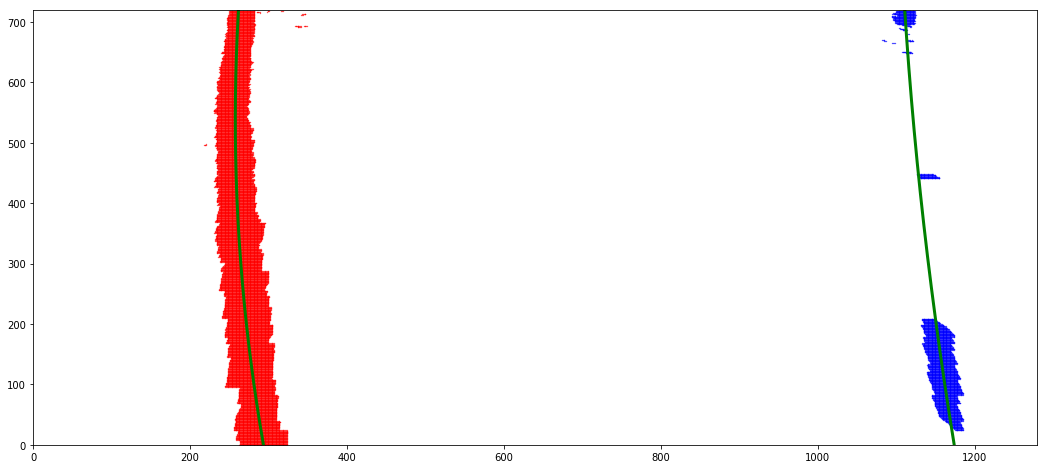

In [7]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #polynomial coefficients of the last n fits of the line
        self.recent_fits = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        
def find_lines_full(warped, margin):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
 
    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    return left_lane_inds, right_lane_inds


def is_good_lines(img, left_line, right_line):
    # The left line and the right line should be roughly parallel
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    leftx = left_line.current_fit[0]*ploty**2 + left_line.current_fit[1]*ploty + left_line.current_fit[2]
    rightx = right_line.current_fit[0]*ploty**2 + right_line.current_fit[1]*ploty + right_line.current_fit[2] 
    
    lane_width = (rightx[-1] - leftx[-1])
    diff = np.mean(rightx - leftx)
    if abs(lane_width - diff) > 150:
        return False
    
    # The curvature should be similar
    if left_line.current_fit[0] > 0 and right_line.current_fit[0] < 0:
        return False

    if left_line.current_fit[0] < 0 and right_line.current_fit[0] > 0:
        return False
    
    return True;


def find_lines(warped, left_line, right_line):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    if left_line.detected and right_line.detected:
        left_fit = left_line.best_fit
        right_fit = right_line.best_fit
    
        # Search from the last lane center
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    else:
        left_lane_inds, right_lane_inds = find_lines_full(warped, margin)
  
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_line.detected = (leftx.size > 0)
    right_line.detected = (rightx.size > 0)
    if left_line.detected is False or right_line.detected is False:
        return

    # Fit a second order polynomial to each    
    right_fit = np.polyfit(righty, rightx, 2)        
    left_fit = np.polyfit(lefty, leftx, 2)        
        
    left_line.current_fit = left_fit
    right_line.current_fit = right_fit
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    left_line.allx = leftx
    right_line.allx = rightx
    left_line.ally = lefty
    right_line.ally = righty
    
    if is_good_lines(warped, left_line, right_line) is False:
        if len(left_line.recent_fits) == 0:
            left_line.detected = False
      
        if len(right_line.recent_fits) == 0:
            right_line.detected = False    
                    
        return    
  
    left_line.recent_fits.append(left_fit)
    right_line.recent_fits.append(right_fit)

    # keep the last 5 measurements
    if len(left_line.recent_fits) > MOVING_AVERAGE_N:
        left_line.recent_fits.pop(0)

    if len(right_line.recent_fits) > MOVING_AVERAGE_N:
        right_line.recent_fits.pop(0)

    # Average the measurements
    left_line.best_fit = np.mean(np.asarray(left_line.recent_fits), axis=0)
    right_line.best_fit = np.mean(np.asarray(right_line.recent_fits), axis=0)
        
    left_line.bestx = left_line.best_fit[0]*ploty**2 + left_line.best_fit[1]*ploty + left_line.best_fit[2]
    right_line.bestx = right_line.best_fit[0]*ploty**2 + right_line.best_fit[1]*ploty + right_line.best_fit[2]        
        
    # Measure radius of curvature in meters            
    left_curverad, right_curverad = lane_curvature(ploty, left_line.bestx, right_line.bestx)
    left_line.radius_of_curvature = left_curverad
    right_line.radius_of_curvature = right_curverad
  
    return


def plot_line_pixels(img):
    undist = undistort(img, mtx, dist)
    thresholded_binary, white, yellow = thresholded_binary_image(undist)
    warped, Minv = warp_image(thresholded_binary)
  
    find_lines(warped, left_line, right_line)
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    
    mark_size = 0.3
    plt.figure(figsize=(18, 8))
    plt.plot(left_line.allx, left_line.ally, 'o', color='red', markersize=mark_size)
    plt.plot(right_line.allx, right_line.ally, 'o', color='blue', markersize=mark_size)
    plt.xlim(0, img.shape[1])
    plt.ylim(0, img.shape[0])
    plt.plot(left_line.bestx, ploty, color='green', linewidth=3)
    plt.plot(right_line.bestx, ploty, color='green', linewidth=3)
    plt.show()

left_line = Line()
right_line = Line()
img = mpimg.imread('test_images/test1.jpg')
plot_line_pixels(img)


## Build the pipeline

This is the core part of this project. The overview of my pipeline is as follows:
1. Calibrate the camera (only needed to be performed once for a given camera)
2. Undistort the image
3. Apply color thresholds (white and yellow) to the image
4. Warp the image to have a bird's-eye view of the image
5. Find the lane lines in the warped image
6. Compute the radius of curvature and the vehicle position with respect to center
7. Warp the found lane boundaries back to the image
8. Draw the radius of curvature and the vehicle offset onto the image

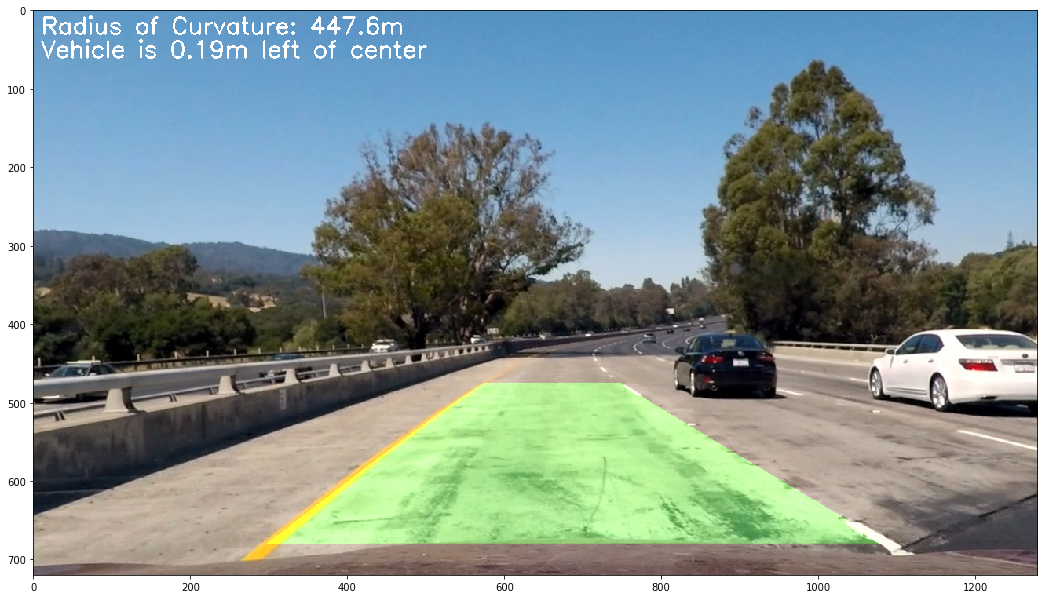

In [8]:
def draw_lane(warped, ploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    return color_warp


def draw_warped_image(warped, ploty, left_fitx, right_fitx):
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return out_img


def draw_diagnostics_image(dst, x, y, src_binary, scale=(0.2, 0.2), title=None):
    resized = cv2.resize(src_binary, (0, 0), fx=scale[0], fy=scale[1])
    if len(resized.shape) == 2:
        resized = np.dstack((resized, resized, resized))*255
    
    dst[y:y+resized.shape[0], x:x+resized.shape[1]] = resized
    
    if title is not None:
        cv2.putText(dst, title, 
                (x, y + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,255))

    return

    
def process_image(img, verbose=False):
    # Correct distortion
    undist = undistort(img, mtx, dist)

    # Apply color or gradient thresholds to the undistorted image to identify lane lines
    thresholded_binary, white_binary, yellow_binary = thresholded_binary_image(undist)

    # Warp the thresholded image
    warped, Minv = warp_image(thresholded_binary)

    # Find lane lines in the warped image
    find_lines(warped, left_line, right_line)

    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    color_warp = draw_lane(warped, ploty, left_line.bestx, right_line.bestx)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    
    # Combine the result with the undistorted image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    offset = 30
    if DEBUG == True:
        out_img = draw_warped_image(warped, ploty, left_line.bestx, right_line.bestx)    
        draw_diagnostics_image(result, 0, 0, out_img)
        draw_diagnostics_image(result, 300, 0, white_binary, title='White')
        draw_diagnostics_image(result, 600, 0, yellow_binary, title='Yellow')
        draw_diagnostics_image(result, 900, 0, thresholded_binary, title='Combined')
        offset = 190

    # Show the radius of lane curvature
    cv2.putText(result, "Radius of Curvature: {0:.1f}m".format(
                (left_line.radius_of_curvature + right_line.radius_of_curvature) / 2),
                (10, offset), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)

    # Show the vehicle position with respect to center:
    pos = vehicle_pos(warped, left_line.bestx, right_line.bestx)
    cv2.putText(result, "Vehicle is {0:.2f}m {1} of center".format(
                abs(pos), "right" if pos > 0. else "left"), 
                (10, offset + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)
    
    return result


left_line = Line()
right_line = Line()

img = mpimg.imread('test_images/test1.jpg')
processed = process_image(img, verbose=True) 
plt.figure(figsize=(18, 16))
plt.imshow(processed)
plt.show()

## Test on the project video

In [9]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left_line = Line()
right_line = Line()

video_output = 'output_videos/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [01:09<00:00, 18.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

CPU times: user 3min 53s, sys: 2.48 s, total: 3min 56s
Wall time: 1min 9s


## Optional Challenge Video

The graident based thresholding would have difficulty on this challenge video because of the paved roads that could cause the pipeline to think it is a lane line. The color thresholding can handle most part of the video except the bridge scene. You need to employ smoothing and outlier rejection techniques to overcome it.

In [10]:
left_line = Line()
right_line = Line()

video_output = 'output_videos/challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

[MoviePy] >>>> Building video output_videos/challenge_video_output.mp4
[MoviePy] Writing video output_videos/challenge_video_output.mp4


100%|██████████| 485/485 [00:25<00:00, 20.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_output.mp4 

CPU times: user 1min 30s, sys: 1.2 s, total: 1min 31s
Wall time: 25.4 s


## Optional Harder Challenge Video

It was painful to watch my pipeline working on this video. The pipeline doesn't work on it at all. The method to find white lane lines needs to be improved a lot to be able to pass the brutal conditions presented in this video.

In [11]:
left_line = Line()
right_line = Line()

video_output = 'output_videos/harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

[MoviePy] >>>> Building video output_videos/harder_challenge_video_output.mp4
[MoviePy] Writing video output_videos/harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [01:16<00:00, 15.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video_output.mp4 

CPU times: user 4min 5s, sys: 2.92 s, total: 4min 8s
Wall time: 1min 16s
